In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from torch.optim import Adam

import gymnasium as gym


**Theory to Practice**

1. When defining the advantage function, they fix the value of the Value function at the beginning of each episode to avoid unstable moving average computation
2. Normalize the advantage function to have zero mean and unit variance

**Architectural Choices**

- Define the feedforwardNN class independently and inherit it from nn.Module.
- Have a specific _init_hyperparameters method to initialize the hyperparameters to not overload the __init__ method.

**Optimization Tricks**

In [ ]:
class Feedforward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Feedforward, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, obs):
        # Convert obs to tensor
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype = torch.float)
        # Forward pass
        obs = F.relu(self.fc1(obs))
        obs = self.fc2(obs)
        return obs

In [ ]:
class PPO():

    def __init__(self,env):

        # Hyperparameters
        self.init_parameters = self._init_hyperparameters()
        # Environment
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.shape[0]
        # NN
        self.actor = Feedforward(self.obs_dim, self.hidden_dim, self.act_dim) # Policy
        self.critic = Feedforward(self.obs_dim,self.hidden_dim, 1)            # Value function
        # Optimizer
        self.actor_opti = Adam(self.actor.parameters(), lr = self.lr)
        self.critic_opti = Adam(self.critic.parameters(), lr = self.lr)
        # Extra Instances
        self.cov_vect = torch.full((self.act_dim, ), fill_value = 0.5) # standard deviation vector
        self.cov_mat = torch.diag(self.cov_vect)                       # [act_dim, act_dim]

    def _init_hyperparameters(self):

        self.timesteps_per_batch       = 4000
        self.max_timesteps_per_episode = 1000
        self.gamma                     = 0.95
        self.n_updates_per_iteration   = 5
        self.clip                      = 0.2
        self.lr                        = 0.005
        self.hidden_dim                = 10

    def rollout(self):
        """Generate time_steps_per_batch in multiple episodes each 
        of maximum length max_timesteps_per_episode
        """
        # Batch data
        batch_obs = []
        batch_acts = []
        batch_log_probs = []
        batch_rews = []
        batch_rgts = [] # Batch rewards-to-go
        batch_lens = [] # Episiodic length in batch

        current_timesteps = 0
        while current_timesteps < self.timesteps_per_batch:
            
            # Initialization
            ep_rews = [] # special format for rgts
            obs, _ = self.env.reset() # Type= (np.ndarray, dict)
            done = False

            for ep_t in range(self.max_timesteps_per_episode):
                # Collect observations
                batch_obs.append(obs)
                action, log_probs = self.get_action(torch.tensor(obs, dtype = torch.float))
                obs, rew, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                # Collect reward, action and log_prob
                ep_rews.append(rew)
                batch_acts.append(action)
                batch_log_probs.append(log_probs)

                current_timesteps += 1
                if done : break # If the agent completed the task finish

            # Collect episodic length and rewards
            current_timesteps += ep_t
            batch_rews.append(ep_rews)            
            batch_lens.append(ep_t + 1)

        # Transform into desired format (Torch)
        batch_obs       = torch.tensor(batch_obs, dtype = torch.float)
        batch_acts      = torch.tensor(batch_acts, dtype = torch.float)
        batch_log_probs = torch.tensor(batch_log_probs, dtype = torch.float)

        batch_rgts = self.compute_rgts(batch_rews)

        return batch_obs,batch_acts, batch_log_probs, batch_rgts, batch_lens

    def compute_rgts(self, batch_rews: list[list[float]]) -> torch.Tensor:
        "Compute RTG for each episode in a batch"

        batch_rgts = []

        for ep_rews in batch_rews: # iteration: number episode
            ep_rgts = []
            discounted_sum = 0
            for rew in reversed(ep_rews): # iteration: steps of the episode
                discounted_sum = rew + self.gamma * discounted_sum
                ep_rgts.insert(0,discounted_sum) # We need the history of rgts at each time steps
            batch_rgts.extend(ep_rgts)
        
        return torch.tensor(batch_rgts, dtype = torch.float)

    def get_action(self, obs: torch.Tensor) -> tuple[np.ndarray, torch.Tensor]:
        "Generate an action as a sample of a Multivariate normal distribution"
        # Query actor network for an action
        mean = self.actor(obs) # Call NN (self.actor.forward(obs))
        dist = MultivariateNormal(mean, self.cov_mat)

        # Generate sample from the distribution
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action.detach().numpy(), log_prob.detach()

    def learn(self, total_timesteps: int): 

        current_timestep = 0

        while current_timestep < total_timesteps:
            
            # Rollout 
            batch_obs, batch_acts, batch_log_probs, batch_rgts, batch_lens = self.rollout()
            # Update number steps
            current_timestep += np.sum(batch_lens)

            # Calculate V_(k,phi)
            V_k, _ = self.evaluate(batch_obs, batch_acts)
            # Calculate advantage
            A_k = batch_rgts - V_k.detach() # Remove computational graph
            # Normalize advantage function
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)

            for _ in range(self.n_updates_per_iteration):
                # Calculate V and phi_theta(a_t|s_t)
                V, cur_log_probs = self.evaluate(batch_obs, batch_acts)
                # Ratio
                ratios = torch.exp(cur_log_probs - batch_log_probs)
                # Calculate surrogate losses
                surr1 = ratios * A_k
                surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k
                # Calculate losses
                actor_loss = (-torch.min(surr1,surr2)).mean()
                critic_loss = nn.MSELoss()(V,batch_rgts)

                # Calculate gradient and perform backward propagation
                self.actor_opti.zero_grad()
                actor_loss.backward(retain_graph = True) # Add this parameter as the computations graphs overlap
                self.actor_opti.step()

                self.critic_opti.zero_grad()
                critic_loss.backward()
                self.critic_opti.step()

        
    def evaluate(self, batch_obs: torch.Tensor, batch_action: torch.Tensor) -> torch.Tensor:
        """
        Value function at batch k: V_(k,phi) and log probs
        We compute the prob of taking an action w.r.t current policy defined by the NN
        """
        # We need the value at each state given the obs sequence of the batch
        V = self.critic(batch_obs).squeeze()
        # Compute log probs in the same fashion to get_action
        mean = self.actor(batch_obs)
        dist = MultivariateNormal(mean, self.cov_mat)
        log_probs = dist.log_prob(batch_action)

        return V, log_probs

-----

In [68]:
env = gym.make("Pendulum-v1")
model = PPO(env)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)


In [ ]:
total_timesteps = 100000
model.learn(total_timesteps)

In [46]:
batch_obs, batch_acts, batch_log_probs, batch_rgts, batch_lens = model.rollout()


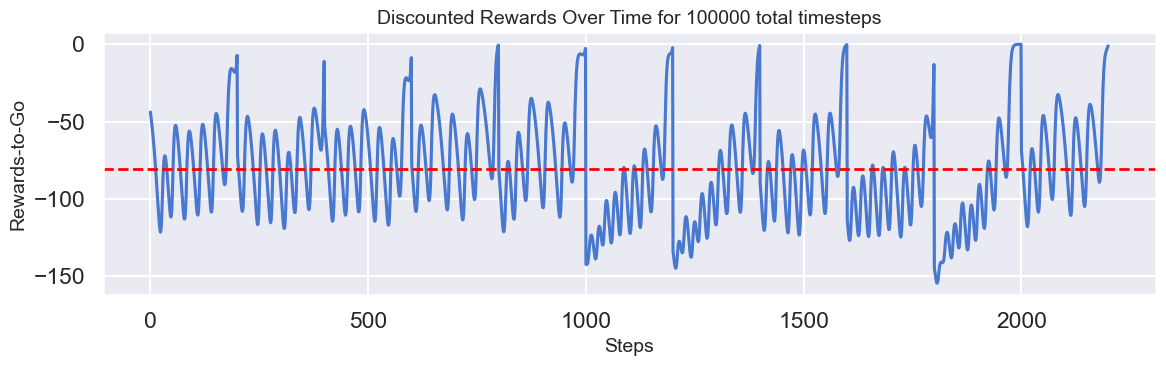

In [ ]:
sns.set(style="darkgrid", context="talk", palette="muted")

plt.figure(figsize=(12, 4))

sns.lineplot(data=batch_rgts)
plt.axhline(y = batch_rgts.mean(), color="red", linestyle = "--", linewidth = 2, label = "Mean Reward")

plt.xlabel("Steps", fontsize=14)
plt.ylabel("Rewards-to-Go", fontsize=14)
plt.title(f"Discounted Rewards Over Time for {total_timesteps} total timesteps", fontsize=14)

# Improve layout
plt.tight_layout()
plt.show()
